In [316]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import matplotlib.dates as mdates
from scipy.signal import argrelextrema


[*********************100%***********************]  1 of 1 completed


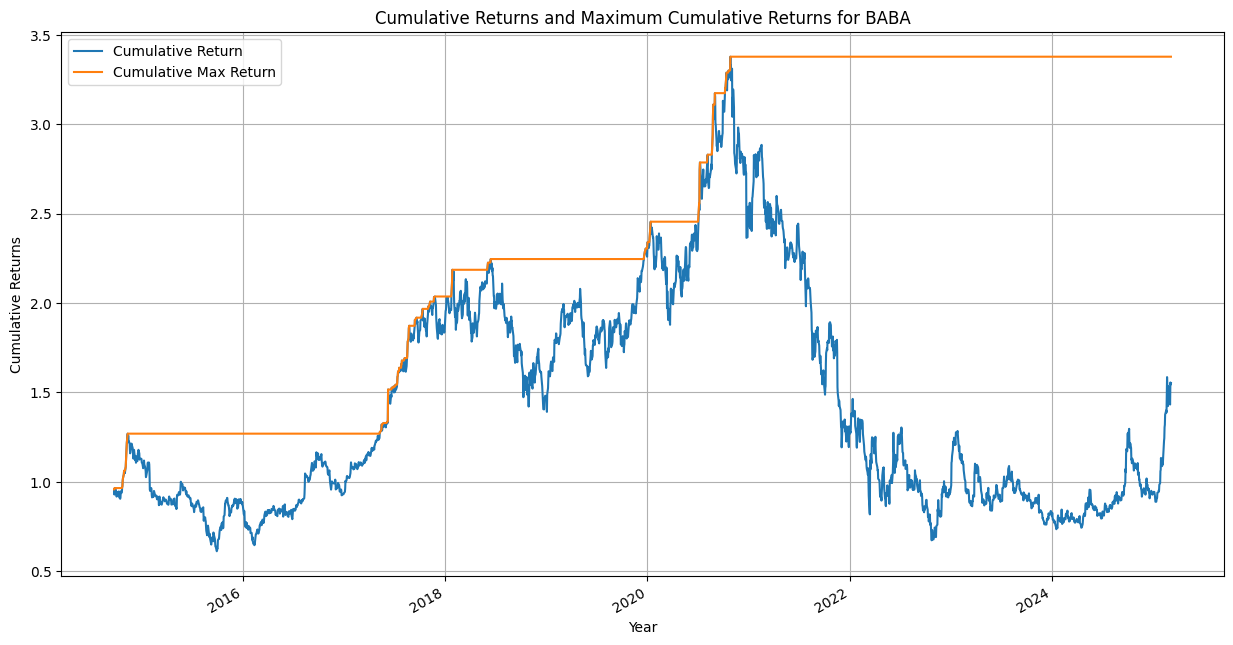

/var/folders/2r/j5lhlppd6tqd8wf9zh69tb3c0000gn/T/ipykernel_64316/3976947781.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  max_drawdown_3m = drawdown.resample('3M').max()


Overall Max Drawdown: 2.7051869376858635
Max Recovery Period: 911 days, 0:00:00

Recovery period from 2014-09-22 00:00:00 to 2014-09-24 00:00:00: 2 days, 0:00:00
Recovery period from 2014-09-24 00:00:00 to 2014-10-21 00:00:00: 27 days, 0:00:00
Recovery period from 2014-10-21 00:00:00 to 2014-10-22 00:00:00: 1 day, 0:00:00
Recovery period from 2014-10-22 00:00:00 to 2014-10-23 00:00:00: 1 day, 0:00:00
Recovery period from 2014-10-23 00:00:00 to 2014-10-24 00:00:00: 1 day, 0:00:00
Recovery period from 2014-10-24 00:00:00 to 2014-10-27 00:00:00: 3 days, 0:00:00
Recovery period from 2014-10-27 00:00:00 to 2014-10-28 00:00:00: 1 day, 0:00:00
Recovery period from 2014-10-28 00:00:00 to 2014-11-03 00:00:00: 6 days, 0:00:00
Recovery period from 2014-11-03 00:00:00 to 2014-11-04 00:00:00: 1 day, 0:00:00
Recovery period from 2014-11-04 00:00:00 to 2014-11-05 00:00:00: 1 day, 0:00:00
Recovery period from 2014-11-05 00:00:00 to 2014-11-06 00:00:00: 1 day, 0:00:00
Recovery period from 2014-11-06 00

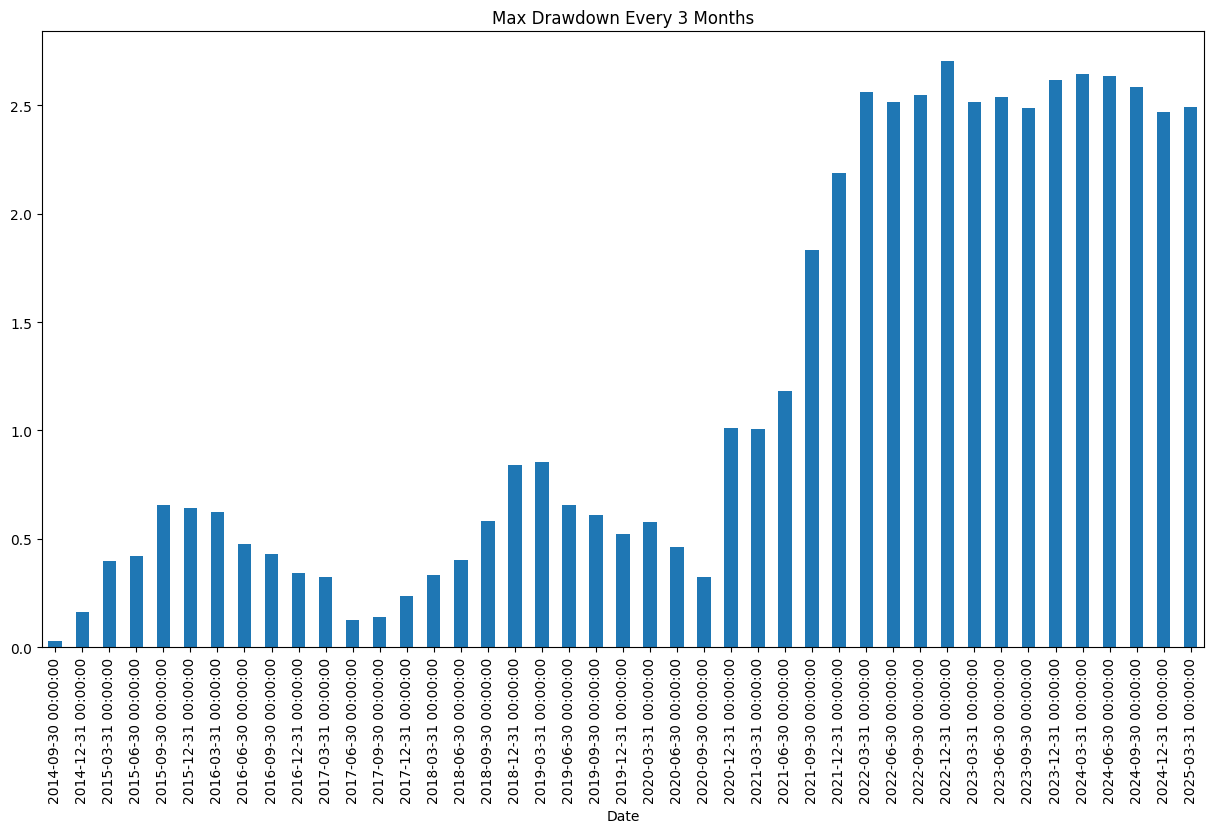

In [317]:
ticker = input("Ticker Symbol: ").upper()
data = yf.download(ticker, period='max',interval='1d')
data['Return'] = data['Close'].pct_change()  
data['Log Returns'] = np.log(data['Close'] / data['Close'].shift(1)) 
data.dropna(inplace=True)

data['cumret'] = data['Log Returns'].cumsum().apply(np.exp)  
data['cummax'] = data['cumret'].cummax()  

drawdown = data['cummax'] - data['cumret']
drawdown.max()
temp = drawdown[drawdown == 0] # Recover Points
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime()) # Recovery Time
periods[12:15]

ax = data[['cumret', 'cummax']].dropna().plot(figsize=(15, 8))
ax.set_title(f'Cumulative Returns and Maximum Cumulative Returns for {ticker}')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Returns')
ax.legend(['Cumulative Return', 'Cumulative Max Return'])
plt.grid(True)
plt.show()

# Overall maximum drawdown over the entire period
print("Overall Max Drawdown:", drawdown.max())
print("Max Recovery Period:", periods.max())
print()

## ERROR LOOK FOR MAX DRAWDOWN WITHIN THAT PERIOD 
# Resample the drawdown series by 6 months and take the maximum in each period.
max_drawdown_3m = drawdown.resample('3M').max()
max_drawdown_3m.plot(kind='bar', title='Max Drawdown Every 3 Months', figsize=(15, 8))

temp = drawdown[drawdown == 0]  # Recovery Points (when drawdown is zero)
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime())  # Recovery Time
recovery_dates = temp.index.to_pydatetime()
recovery_periods = recovery_dates[1:] - recovery_dates[:-1]

for start, end, period in zip(recovery_dates[:-1], recovery_dates[1:], recovery_periods):
    print(f"Recovery period from {start} to {end}: {period}")

Major Drawdown Events (7 found):
Peak Date:2014-11-10  Trough Date:2015-09-28  Recovery Date:2017-05-09    Drawdown Percentage:  51.8%  Drawdown Period:   911 days
Peak Date:2017-11-24  Trough Date:2017-12-05  Recovery Date:2018-01-23    Drawdown Percentage:  11.6%  Drawdown Period:    60 days
Peak Date:2018-01-26  Trough Date:2018-04-06  Recovery Date:2018-06-04    Drawdown Percentage:  18.4%  Drawdown Period:   129 days
Peak Date:2018-06-14  Trough Date:2019-01-03  Recovery Date:2019-12-20    Drawdown Percentage:  38.1%  Drawdown Period:   554 days
Peak Date:2020-01-13  Trough Date:2020-03-23  Recovery Date:2020-07-06    Drawdown Percentage:  23.5%  Drawdown Period:   175 days
Peak Date:2020-09-01  Trough Date:2020-09-10  Recovery Date:2020-10-08    Drawdown Percentage:  10.2%  Drawdown Period:    37 days
Peak Date:2020-10-27  Trough Date:2022-10-24  Recovery Date:Ongoing       Drawdown Percentage:  80.1%  Drawdown Period:  1592 days


/Users/edisontanchienyan/Library/Python/3.9/lib/python/site-packages/matplotlib/text.py:1467: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


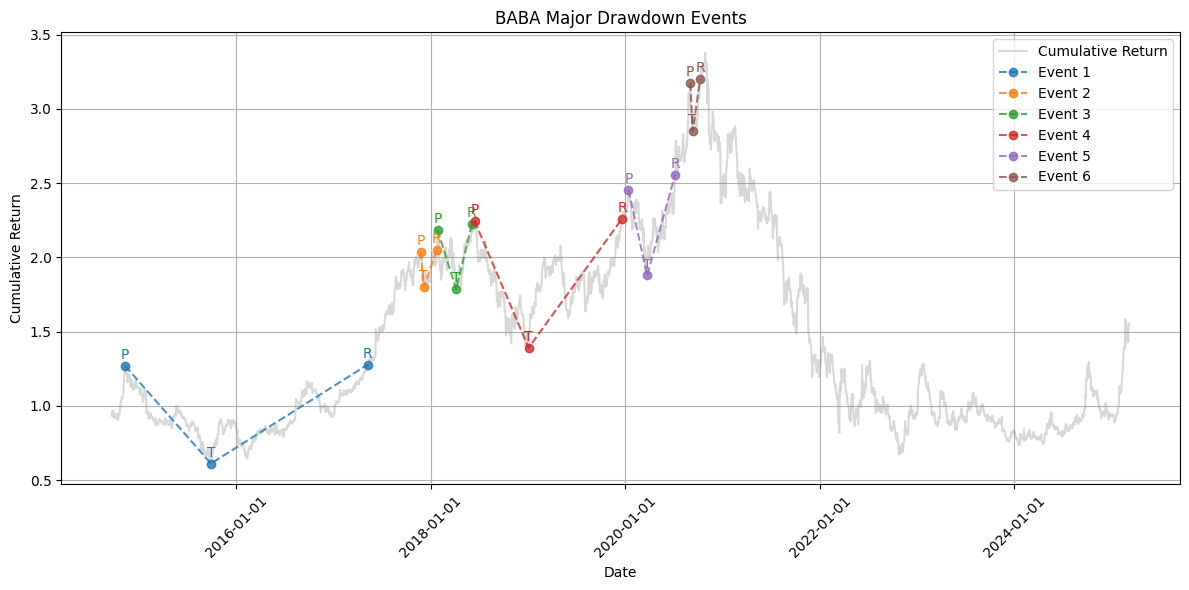

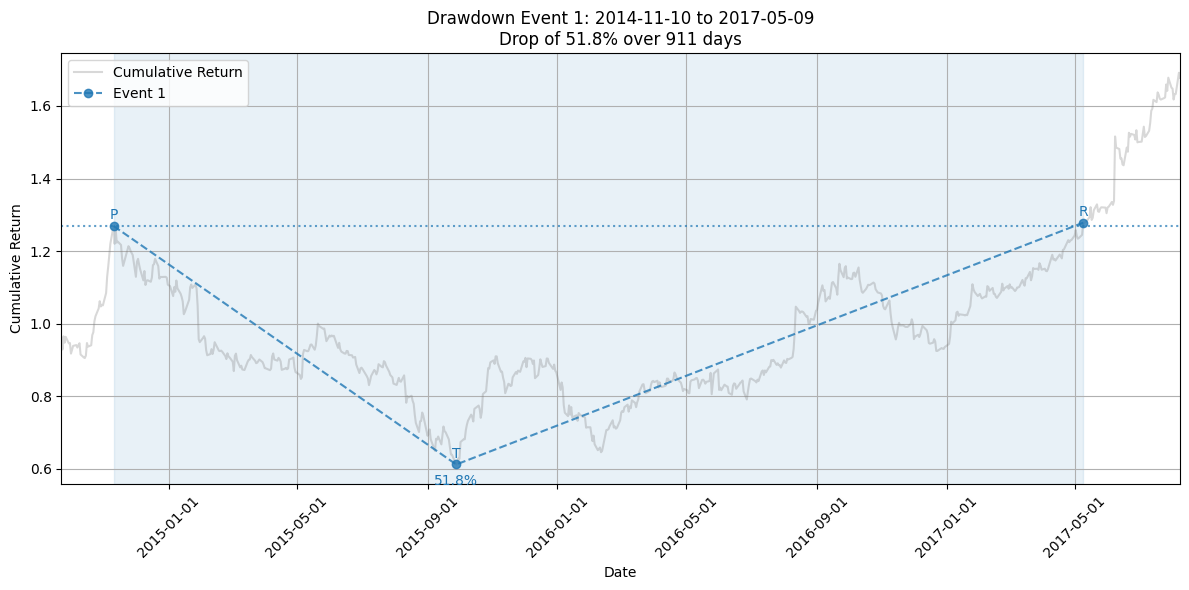

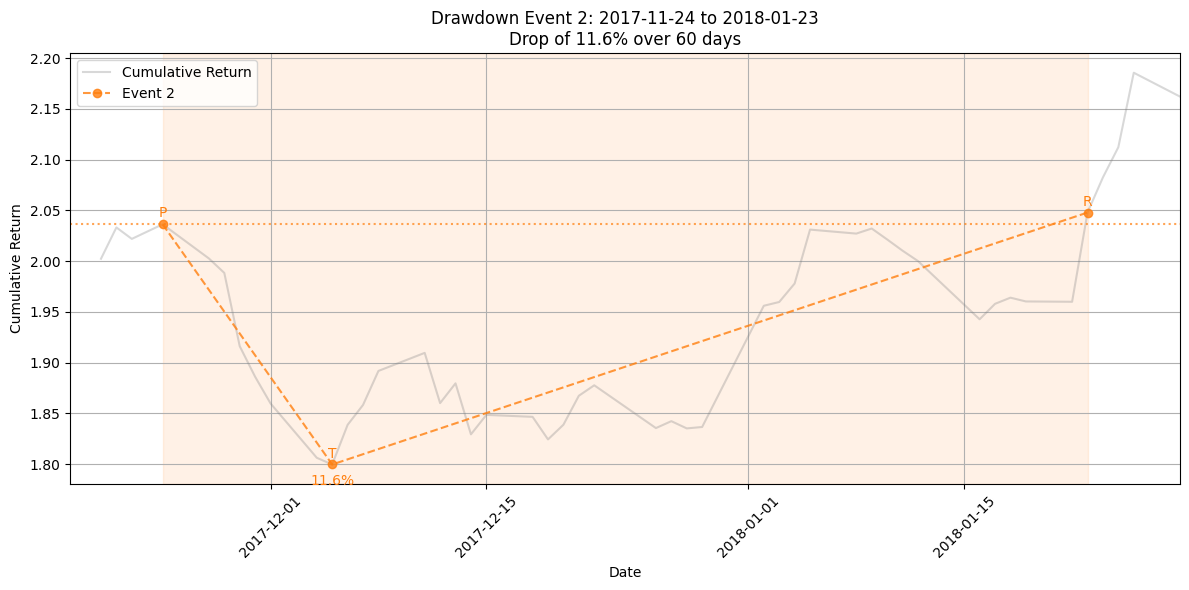

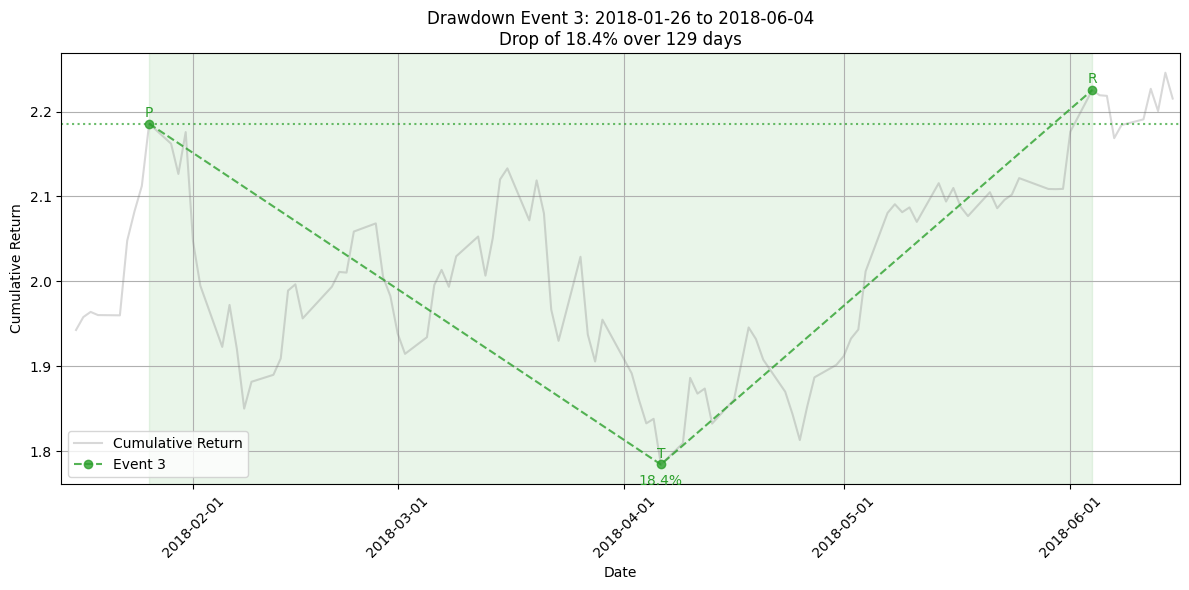

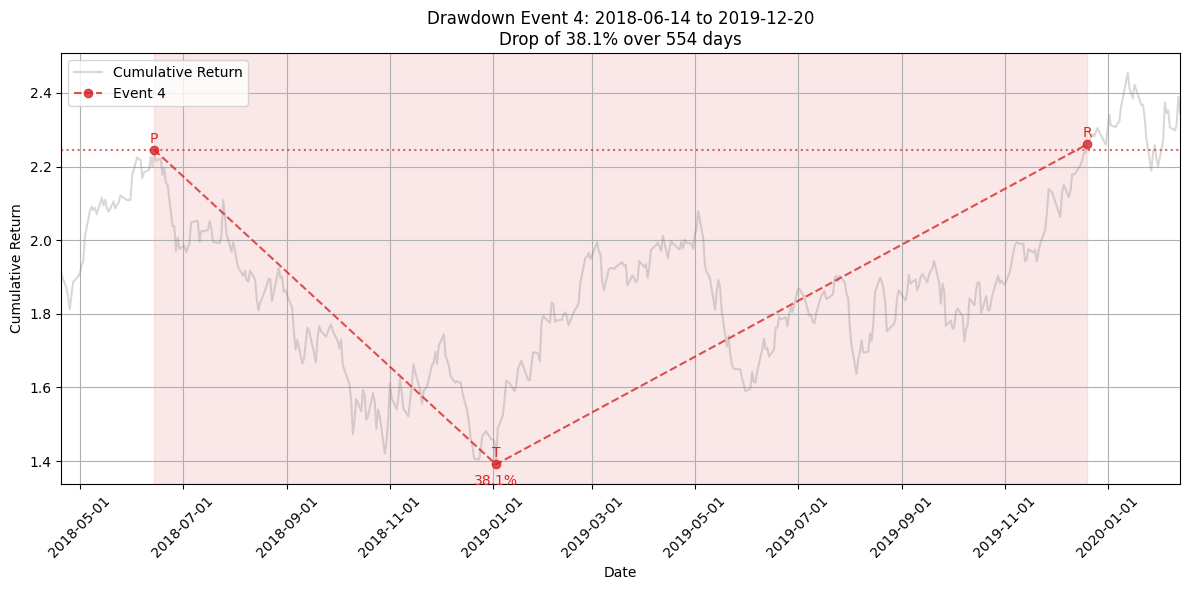

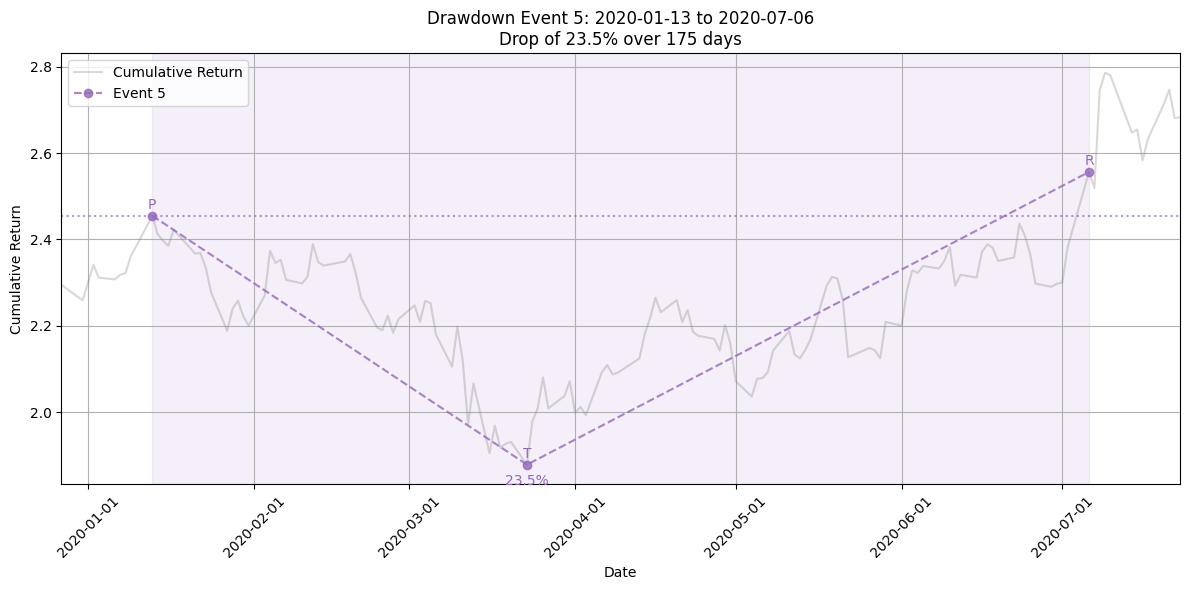

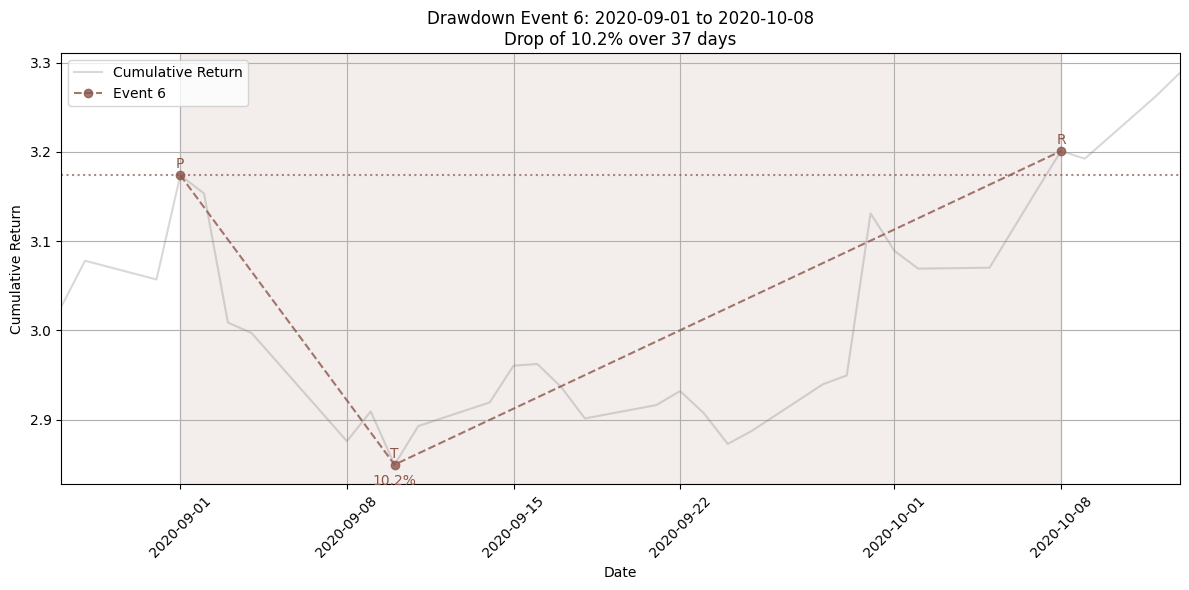

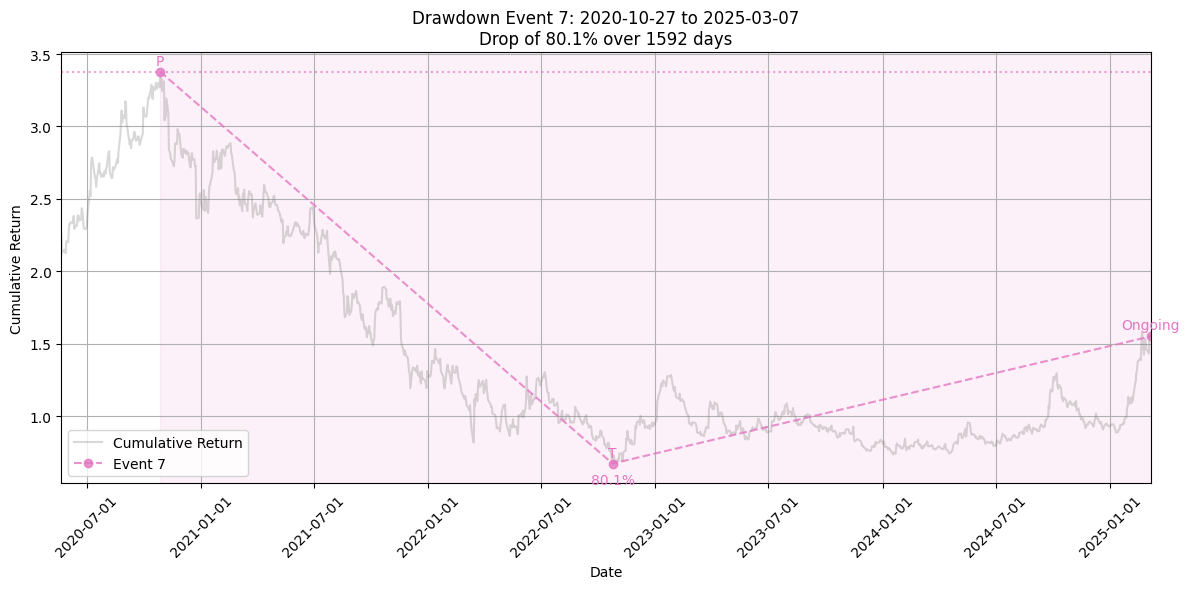

In [318]:
drawdown_events = []
threshold = 0.10  
current_peak_date = data.index[0]
current_peak_value = data['cumret'].iloc[0]
in_drawdown = False
trough_value = None
trough_date = None

for date, row in data.iterrows():
    current_value = row['cumret']
    if isinstance(current_value, pd.Series):
        current_value = current_value.iloc[0]

    if not in_drawdown:
        # Update running peak
        if current_value > current_peak_value:
            current_peak_date = date
            current_peak_value = current_value
        
        # Check for drawdown entry
        drawdown = (current_peak_value - current_value) / current_peak_value
        if drawdown >= threshold:
            in_drawdown = True
            trough_date = date
            trough_value = current_value
    else:
        # Update trough during drawdown
        if current_value < trough_value:
            trough_date = date
            trough_value = current_value
        
        # Check for recovery (price returns to original peak level)
        if current_value >= current_peak_value:
            duration = (date - current_peak_date).days
            drawdown_pct = (current_peak_value - trough_value)/current_peak_value * 100
            
            drawdown_events.append({
                'peak_date': current_peak_date,
                'trough_date': trough_date,
                'recovery_date': date,
                'drawdown_pct': drawdown_pct,
                'duration_days': duration
            })
            
            # Reset tracking with new peak starting from recovery
            in_drawdown = False
            current_peak_date = date
            current_peak_value = current_value

# Add any ongoing drawdown at end
if in_drawdown:
    drawdown_events.append({
        'peak_date': current_peak_date,
        'trough_date': trough_date,
        'recovery_date': None,
        'drawdown_pct': (current_peak_value - trough_value)/current_peak_value * 100,
        'duration_days': (data.index[-1] - current_peak_date).days
    })

# Filter and display results
valid_events = [e for e in drawdown_events if e['drawdown_pct'] >= 10]
print(f"Major Drawdown Events ({len(valid_events)} found):")
for event in valid_events:
    recovery_date = event['recovery_date'].date() if event['recovery_date'] else "Ongoing"
    print(f"Peak Date:{event['peak_date'].date()}  Trough Date:{event['trough_date'].date()}  Recovery Date:{recovery_date!s:<12}  "
          f"Drawdown Percentage:{event['drawdown_pct']:>6.1f}%  Drawdown Period:{event['duration_days']:>6} days")

# Visualisation
plt.figure(figsize=(12, 6))
# Optionally, plot the overall cumulative return as a background
plt.plot(data.index, data['cumret'], color='gray', alpha=0.3, label="Cumulative Return")

for i, event in enumerate(valid_events):
    if event['recovery_date']:
        event_dates = [event['peak_date'], event['trough_date'], event['recovery_date']]
        event_values = [data.loc[event['peak_date'], 'cumret'],
                        data.loc[event['trough_date'], 'cumret'],
                        data.loc[event['recovery_date'], 'cumret']]
        color = plt.cm.tab10(i % 10)  # Get a distinct color for each event
        plt.plot(event_dates, event_values, marker='o', linestyle='--', color=color, alpha=0.8, label=f"Event {i+1}")
        # Annotate each key point with a label
        plt.annotate("P", (event['peak_date'], data.loc[event['peak_date'], 'cumret']),
                     textcoords="offset points", xytext=(0, 5), ha='center', color=color)
        plt.annotate("T", (event['trough_date'], data.loc[event['trough_date'], 'cumret']),
                     textcoords="offset points", xytext=(0, 5), ha='center', color=color)
        plt.annotate("R", (event['recovery_date'], data.loc[event['recovery_date'], 'cumret']),
                     textcoords="offset points", xytext=(0, 5), ha='center', color=color)

# Format the x-axis to show dates clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.title(f"{ticker} Major Drawdown Events")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for i, event in enumerate(valid_events):
    # If the event is ongoing (no recovery date), use the last date in data as the recovery reference.
    if event['recovery_date'] is None:
        rec_date = data.index[-1]
        event_duration = (rec_date - event['peak_date']).days
        recovery_label = "Ongoing"
    else:
        rec_date = event['recovery_date']
        event_duration = (rec_date - event['peak_date']).days
        recovery_label = "R"
    
    # Calculate a margin (10% of duration, minimum 5 days)
    margin_days = max(5, int(event_duration * 0.1))
    margin = pd.Timedelta(days=margin_days)
    
    # Define the period to plot; ensure the limits are within the data bounds.
    period_start = event['peak_date'] - margin
    period_end = rec_date + margin
    if period_start < data.index[0]:
        period_start = data.index[0]
    if period_end > data.index[-1]:
        period_end = data.index[-1]
    
    event_period = data.loc[period_start:period_end]
    
    # Create the figure
    plt.figure(figsize=(12, 6))
    
    # Plot overall cumulative return as background
    plt.plot(event_period.index, event_period['cumret'], color='gray', alpha=0.3, label="Cumulative Return")
    
    # Retrieve key values, ensuring scalars are obtained.
    peak_value = data.loc[event['peak_date'], 'cumret']
    if isinstance(peak_value, pd.Series):
        peak_value = peak_value.iloc[0]
    trough_value = data.loc[event['trough_date'], 'cumret']
    if isinstance(trough_value, pd.Series):
        trough_value = trough_value.iloc[0]
    rec_value = data.loc[rec_date, 'cumret']
    if isinstance(rec_value, pd.Series):
        rec_value = rec_value.iloc[0]
    
    # Plot the key points and connecting lines for the event
    event_dates = [event['peak_date'], event['trough_date'], rec_date]
    event_values = [peak_value, trough_value, rec_value]
    color = plt.cm.tab10(i % 10)
    plt.plot(event_dates, event_values, marker='o', linestyle='--', color=color, alpha=0.8, label=f"Event {i+1}")
    
    # Draw a horizontal dashed line at the peak value
    plt.axhline(peak_value, color=color, linestyle=':', alpha=0.7)
    
    # Shade the event period to emphasize the zoomed region
    plt.axvspan(event['peak_date'], rec_date, color=color, alpha=0.1)
    
    # Annotate the points: Peak (P), Trough (T), and Recovery or Ongoing (R/Ongoing)
    plt.annotate("P", (event['peak_date'], peak_value),
                 textcoords="offset points", xytext=(0, 5), ha='center', color=color, fontsize=10)
    plt.annotate("T", (event['trough_date'], trough_value),
                 textcoords="offset points", xytext=(0, 5), ha='center', color=color, fontsize=10)
    plt.annotate(recovery_label, (rec_date, rec_value),
                 textcoords="offset points", xytext=(0, 5), ha='center', color=color, fontsize=10)
    
    # Annotate the drawdown percentage near the trough
    plt.annotate(f"{event['drawdown_pct']:.1f}%", 
                 (event['trough_date'], trough_value),
                 textcoords="offset points", xytext=(0, -15), ha='center', color=color, fontsize=10)
    
    # Format the x-axis for dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title(f"Drawdown Event {i+1}: {event['peak_date'].date()} to {rec_date.date()}\n"
              f"Drop of {event['drawdown_pct']:.1f}% over {event_duration} days")
    plt.xlim(period_start, period_end)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Drawdown events with entry dates:
   Peak Date Trough Date Recovery Date Overall Drawdown Period  \
0 2014-11-10  2015-05-05    2015-05-21                192 days   
1 2015-05-21  2015-09-28    2015-10-12                144 days   
2 2015-11-04  2016-02-11    2016-03-04                121 days   
3 2016-09-22  2016-12-23    2017-01-23                123 days   

   Overall Drawdown Percentage  Recovery Percentage Recovery Duration  \
0                        33.24                18.03           16 days   
1                        38.87                22.50           14 days   
2                        29.07                19.23           22 days   
3                        20.64                13.39           31 days   

  Entry Date  
0        NaT  
1 2015-08-28  
2 2016-01-14  
3 2016-11-04  


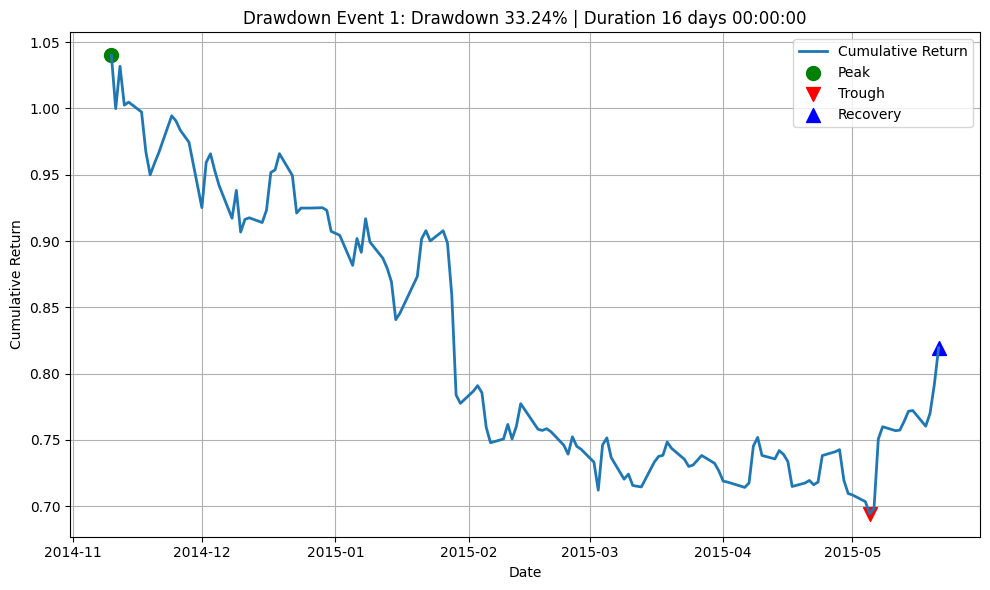

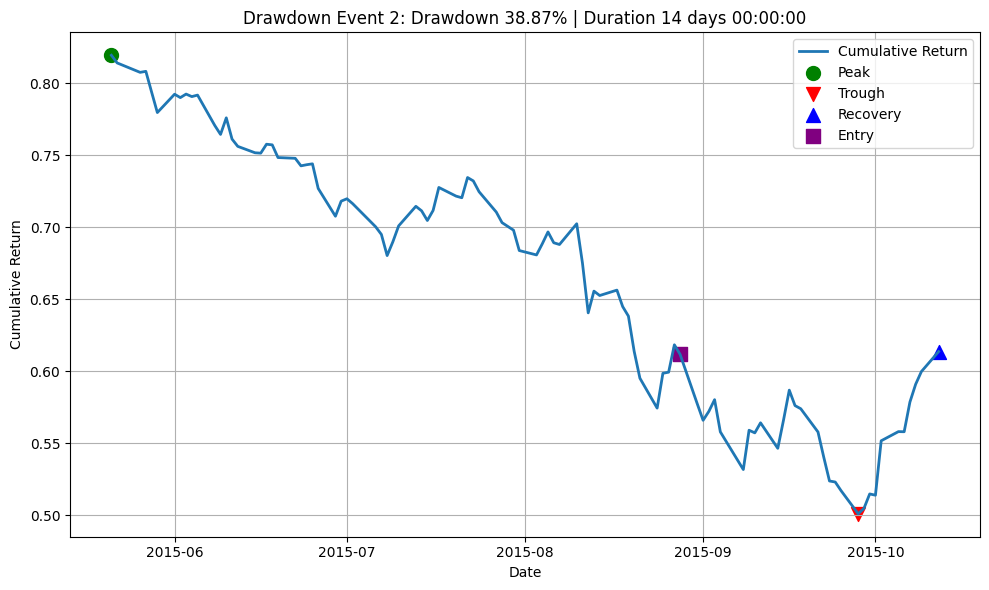

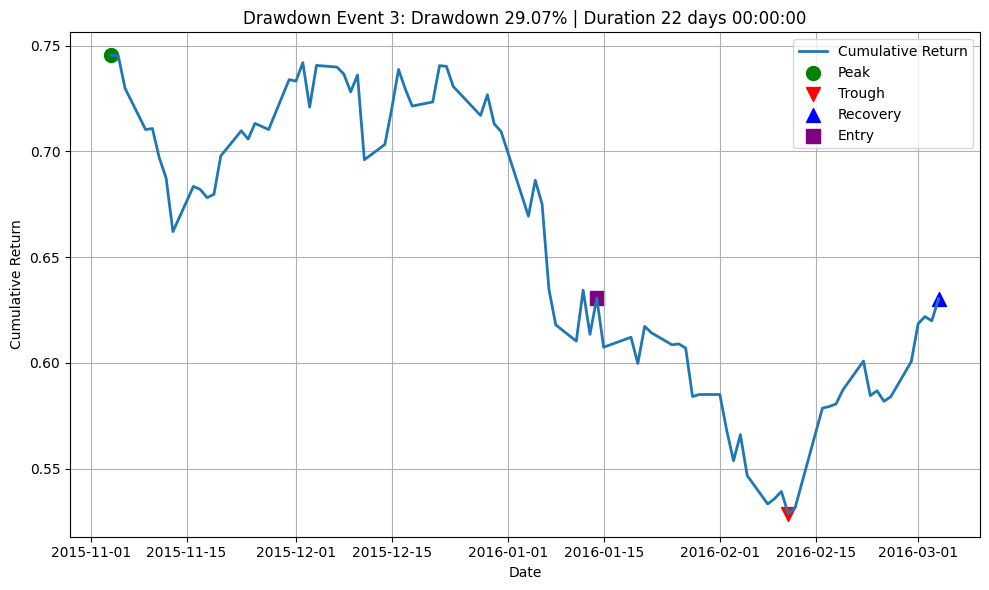

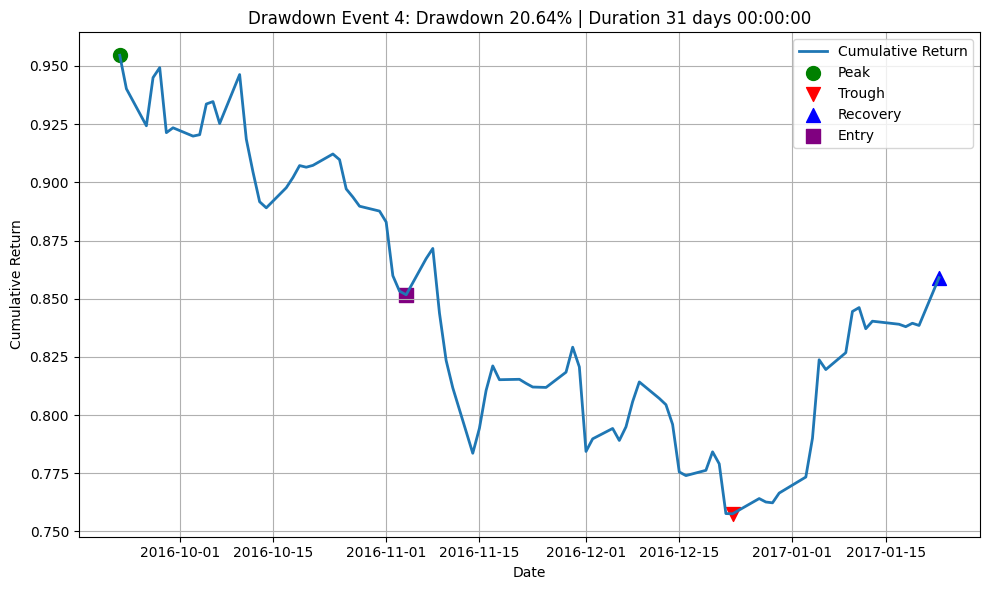

In [319]:
if valid_events:
    first_event = valid_events[0]
    
    # Define the analysis period from the first event's peak until its recovery (or end of data)
    start_date = first_event['peak_date']
    end_date = first_event['recovery_date'] if first_event['recovery_date'] else data.index[-1]
    event_data = data.loc[start_date:end_date].copy()
    
    # Recalculate cumulative returns for this sub-period
    event_data['cumret'] = event_data['Log Returns'].cumsum().apply(np.exp)
    event_data['cummax'] = event_data['cumret'].cummax()
    
    # Initialize variables for the sub-period drawdown analysis
    sub_drawdown_events = []
    current_peak_date = event_data.index[0]
    current_peak_value = event_data['cumret'].iloc[0]
    in_drawdown = False
    trough_value = None
    trough_date = None
    recovery_threshold = 0.1  # the drop (and recovery) threshold
    
    # Loop over the sub-period to identify drawdown events
    for date, row in event_data.iterrows():
        current_value = row['cumret']
        if isinstance(current_value, pd.Series):
            current_value = current_value.iloc[0]
        
        if not in_drawdown:
            # Update the current peak if a new high is reached
            if current_value > current_peak_value:
                current_peak_date = date
                current_peak_value = current_value
            
            # Check if a drop of at least recovery_threshold (i.e., 0.1) has occurred
            drawdown = (current_peak_value - current_value) / current_peak_value
            if drawdown >= recovery_threshold:
                in_drawdown = True
                trough_date = date
                trough_value = current_value
        else:
            # Update trough if a lower value is reached during the drawdown
            if current_value < trough_value:
                trough_date = date
                trough_value = current_value
                recovery_value = current_value
            
            # Check if cumulative return has recovered by recovery_threshold (additive condition)
            if current_value >= trough_value + recovery_threshold:
                drawdown_period = date - current_peak_date
                recovery_value = current_value
                recovery_pct = (recovery_value - trough_value) / trough_value * 100
                drawdown_pct = (current_peak_value - trough_value) / current_peak_value * 100
                duration = date - trough_date  # raw timedelta for recovery duration
                sub_drawdown_events.append({
                    'Peak Date': current_peak_date,
                    'Trough Date': trough_date,
                    'Recovery Date': date,
                    'Overall Drawdown Period': drawdown_period,
                    'Overall Drawdown Percentage': round(drawdown_pct, 2),
                    'Recovery Percentage': round(recovery_pct, 2),
                    'Recovery Duration': duration
                })
                
                # Reset the drawdown state
                in_drawdown = False
                current_peak_date = date
                current_peak_value = current_value

    # If still in drawdown when the loop ends, record the event with no recovery date
    if in_drawdown:
        drawdown_period = event_data.index[-1] - current_peak_date
        final_value = event_data['cumret'].iloc[-1]
        recovery_pct = (final_value - trough_value) / trough_value * 100
        drawdown_pct = (current_peak_value - trough_value) / current_peak_value * 100
        duration = event_data.index[-1] - trough_date
        sub_drawdown_events.append({
            'Peak Date': current_peak_date,
            'Trough Date': trough_date,
            'Recovery Date': None,
            'Overall Drawdown Period': drawdown_period,
            'Overall Drawdown Percentage': round(drawdown_pct, 2),
            'Recovery Percentage': round(recovery_pct, 2),
            'Recovery Duration': duration
        })
    
    # --- Look for entry dates ---
    # For each event with a recovery date, search for dates (strictly before the recovery date)
    # where the cumulative return is equal (within a tolerance) to that at recovery.
    tol = 0.008
    for event in sub_drawdown_events:
        if event['Recovery Date'] is not None:
            recovery_val = event_data.loc[event['Recovery Date'], 'cumret']
            search_period = event_data.loc[event['Peak Date']:event['Recovery Date']]
            search_period = search_period.loc[search_period.index < event['Recovery Date']]
            matching_dates = search_period.index[np.isclose(search_period['cumret'], recovery_val, atol=tol)]
            if not matching_dates.empty:
                event['Entry Date'] = matching_dates[-1]
            else:
                event['Entry Date'] = None
        else:
            event['Entry Date'] = None
    
    # For inspection, print the events with entry dates added
    results_with_entry = pd.DataFrame(sub_drawdown_events)
    print("\nDrawdown events with entry dates:")
    print(results_with_entry)
    
    # --- Plot each event as a separate graph with an entry date marker (if found) ---
    for i, event in enumerate(sub_drawdown_events):
        plot_start = event['Peak Date']
        plot_end = event['Recovery Date'] if event['Recovery Date'] is not None else event_data.index[-1]
        event_period = event_data.loc[plot_start:plot_end]
        
        plt.figure(figsize=(10, 6))
        plt.plot(event_period.index, event_period['cumret'], label='Cumulative Return', lw=2)
        
        plt.scatter(event['Peak Date'], event_data.loc[event['Peak Date'], 'cumret'], 
                    color='green', marker='o', s=100, label='Peak')
        plt.scatter(event['Trough Date'], event_data.loc[event['Trough Date'], 'cumret'], 
                    color='red', marker='v', s=100, label='Trough')
        if event['Recovery Date'] is not None:
            plt.scatter(event['Recovery Date'], event_data.loc[event['Recovery Date'], 'cumret'], 
                        color='blue', marker='^', s=100, label='Recovery')
        if event.get('Entry Date') is not None:
            plt.scatter(event['Entry Date'], event_data.loc[event['Entry Date'], 'cumret'], 
                        color='purple', marker='s', s=100, label='Entry')
        
        plt.title(f"Drawdown Event {i+1}: Drawdown {event['Overall Drawdown Percentage']:.2f}% | Duration {event['Recovery Duration']}")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Summary of Drawdown Events:
   Peak Date Trough Date Recovery Date Overall Drawdown Period  \
0 2014-11-10  2015-05-05    2015-05-13                184 days   
1 2015-05-21  2015-09-08    2015-09-16                118 days   
2 2015-09-16  2015-09-28    2015-10-02                 16 days   
3 2015-11-04  2015-11-13    2015-11-30                 26 days   
4 2015-12-02  2016-02-11    2016-02-19                 79 days   
5 2016-09-22  2016-12-23    2017-01-10                110 days   

   Overall Drawdown Percentage  Recovery Percentage Recovery Duration  
0                        33.24            10.045272            8 days  
1                        35.12            10.375966            8 days  
2                        14.64            10.123716            4 days  
3                        11.18            10.850367           17 days  
4                        28.74            11.078091            8 days  
5                        20.64            11.475975           18 days  


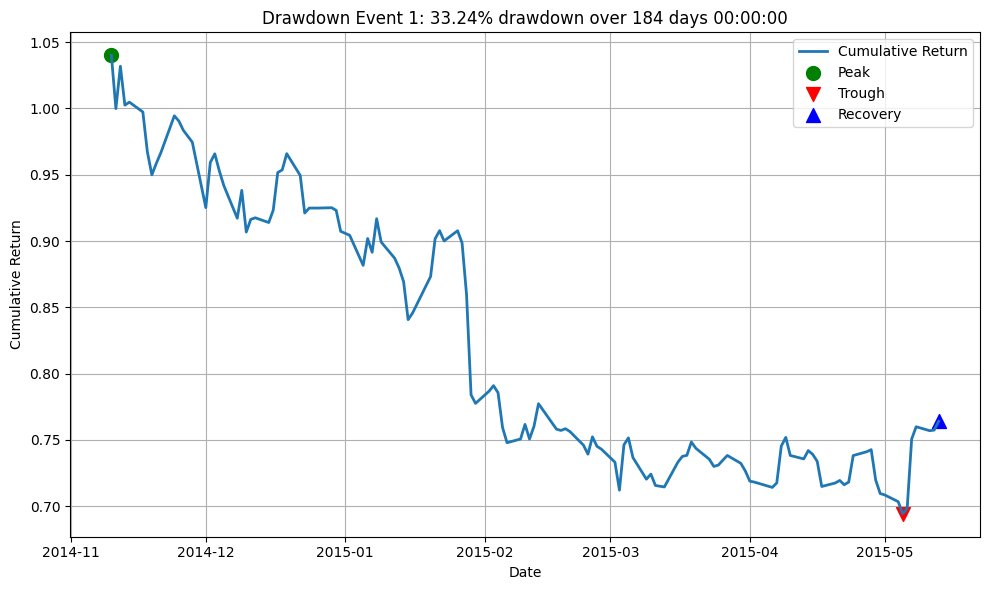

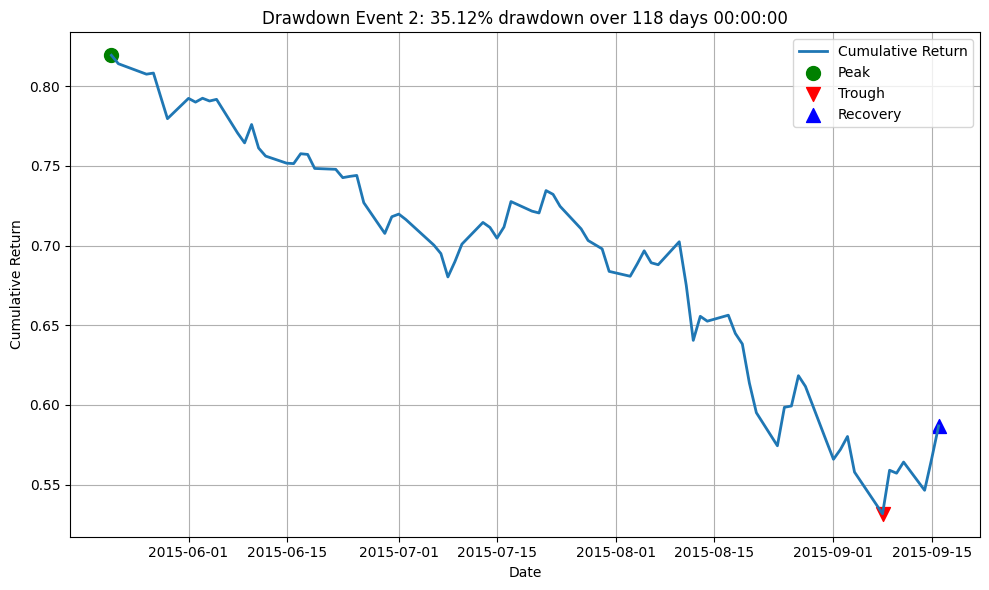

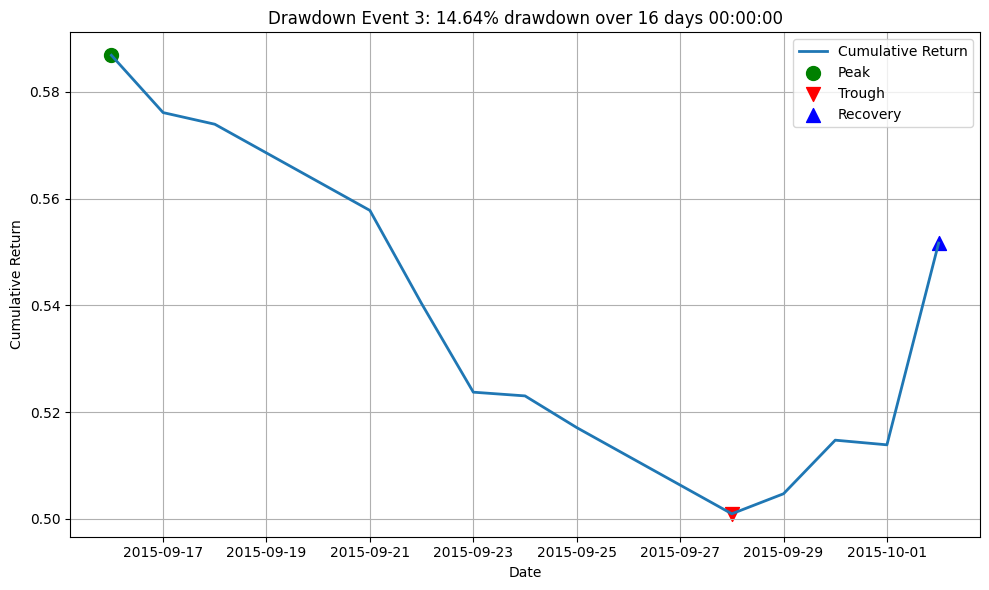

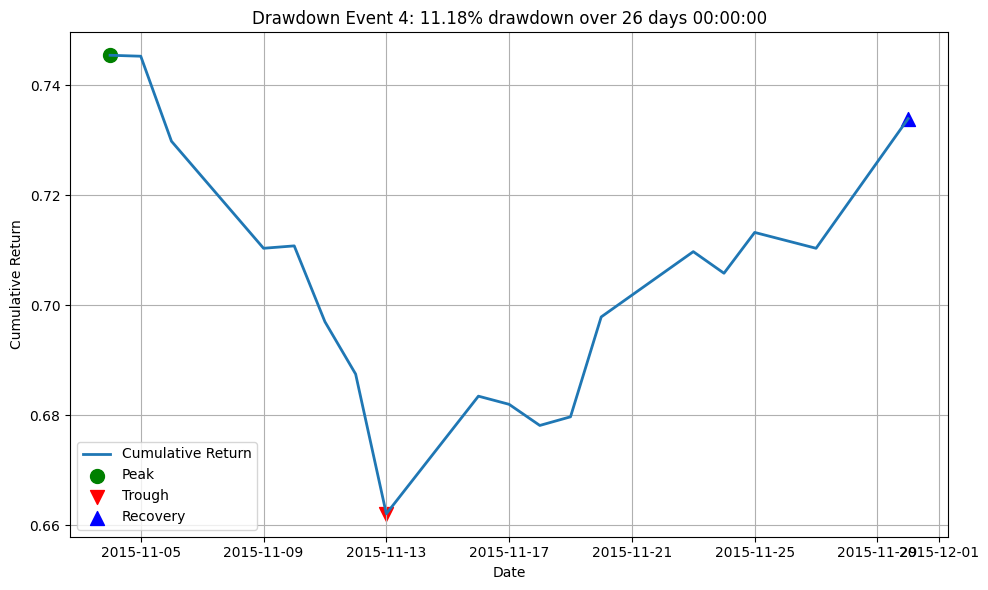

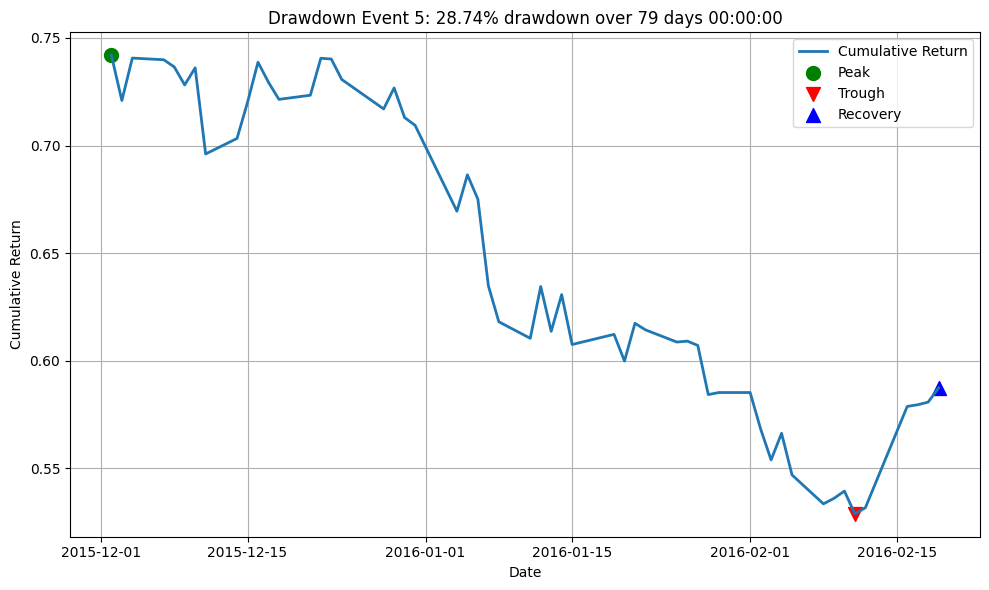

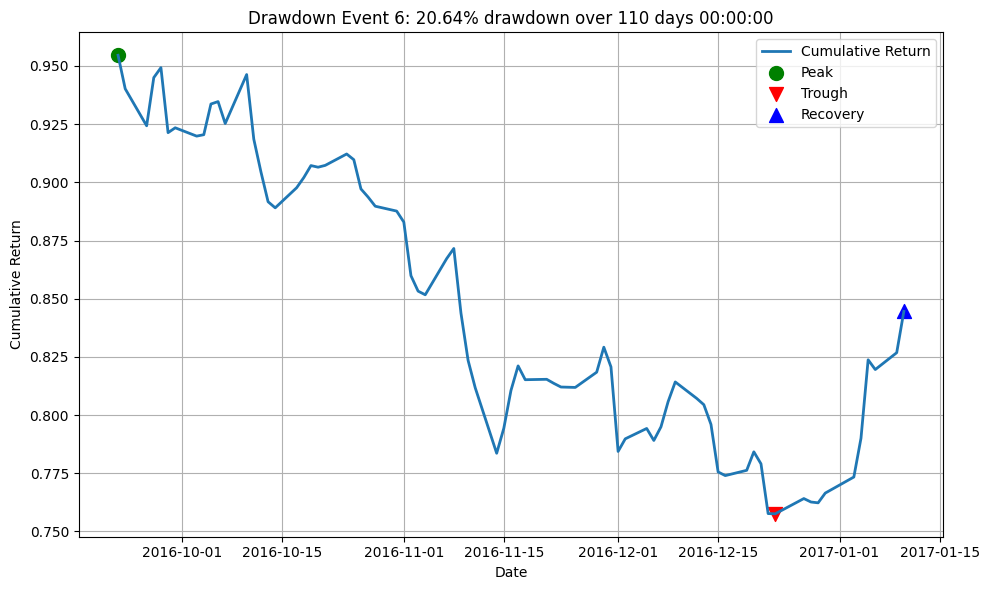

In [322]:
if valid_events:
    first_event = valid_events[0]
    
    # Define the analysis period from the first event's peak until its recovery (or end of data)
    start_date = first_event['peak_date']
    end_date = first_event['recovery_date'] if first_event['recovery_date'] else data.index[-1]
    event_data = data.loc[start_date:end_date].copy()
    
    if event_data.empty:
        print("No data available in the selected period.")
    else:
        # Recalculate cumulative returns for this sub-period
        event_data['cumret'] = event_data['Log Returns'].cumsum().apply(np.exp)
        event_data['cummax'] = event_data['cumret'].cummax()
        
        # Initialize variables for the sub-period drawdown analysis
        sub_drawdown_events = []
        current_peak_date = event_data.index[0]
        current_peak_value = event_data['cumret'].iloc[0]
        in_drawdown = False
        trough_value = None
        trough_date = None
        recovery_threshold = 0.1  # 10% drop (and recovery) threshold
        drop_threshold = 0.1
        # Loop over the sub-period to identify drawdown events
        for date, row in event_data.iterrows():
            current_value = row['cumret']
            # Ensure current_value is a scalar
            if isinstance(current_value, pd.Series):
                current_value = current_value.iloc[0]
            
            if not in_drawdown:
                # Update the current peak if a new high is reached
                if current_value > current_peak_value:
                    current_peak_date = date
                    current_peak_value = current_value
                
                # Check if a drop of at least recovery_threshold (10%) has occurred
                drawdown = (current_peak_value - current_value) / current_peak_value
                if drawdown >= drop_threshold:
                    in_drawdown = True
                    trough_date = date
                    trough_value = current_value
            else:
                # Update trough if a lower value is reached during the drawdown
                if current_value < trough_value:
                    trough_date = date
                    trough_value = current_value
                
                # Check if cumulative return has recovered by at least 10% from the trough
                if current_value >= trough_value * (1 + recovery_threshold):
                    duration = date - trough_date
                    drawdown_period = date - current_peak_date
                    recovery_value = current_value
                    recovery_pct = recovery_pct = (recovery_value - trough_value) / trough_value * 100
                    drawdown_pct = (current_peak_value - trough_value) / current_peak_value * 100
                    sub_drawdown_events.append({
                        'Peak Date': current_peak_date,
                        'Trough Date': trough_date,
                        'Recovery Date': date,
                        'Overall Drawdown Period': drawdown_period,
                        'Overall Drawdown Percentage': round(drawdown_pct, 2),
                        'Recovery Percentage': recovery_pct,
                        'Recovery Duration': duration
                    })
                    
                    # Reset the drawdown state
                    in_drawdown = False
                    current_peak_date = date
                    current_peak_value = current_value

        # If still in drawdown when the loop ends, record the event with no recovery date
        if in_drawdown:
            duration = event_data.index[-1] - trough_date
            drawdown_period = event_data.index[-1] - current_peak_date
            recovery_pct = (recovery_value - trough_value) / trough_value * 100
            drawdown_pct = (current_peak_value - trough_value) / current_peak_value * 100
            sub_drawdown_events.append({
                'Peak Date': current_peak_date,
                'Trough Date': trough_date,
                'Recovery Date': None,
                'Overall Drawdown Percentage': round(drawdown_pct, 2),
                'Overall Drawdown Period': drawdown_period,
                'Recovery Percentage': recovery_pct,
                'Recovery Duration': duration
            })
        
        # Print a summary table of detected drawdown events
        print("Summary of Drawdown Events:")
        events_df = pd.DataFrame(sub_drawdown_events)
        print(events_df)
        
        # --- Plot each event as a separate graph with an entry date marker (if found) ---
        for i, event in enumerate(sub_drawdown_events):
            # Determine the plotting period for this event
            plot_start = event['Peak Date']
            plot_end = event['Recovery Date'] if event['Recovery Date'] is not None else event_data.index[-1]
            event_period = event_data.loc[plot_start:plot_end]
            
            plt.figure(figsize=(10, 6))
            plt.plot(event_period.index, event_period['cumret'], label='Cumulative Return', lw=2)
            
            # Function to safely retrieve a scalar value
            def get_value(date, col):
                val = event_data.loc[date, col]
                return val.iloc[0] if isinstance(val, pd.Series) else val
            
            # Peak point and annotation
            peak_val = get_value(event['Peak Date'], 'cumret')
            plt.scatter(event['Peak Date'], peak_val, color='green', marker='o', s=100, label='Peak')
            
            # Trough point and annotation
            trough_val = get_value(event['Trough Date'], 'cumret')
            plt.scatter(event['Trough Date'], trough_val, color='red', marker='v', s=100, label='Trough')
            
            # Recovery point and annotation (if available)
            if event['Recovery Date'] is not None:
                recovery_val = get_value(event['Recovery Date'], 'cumret')
                plt.scatter(event['Recovery Date'], recovery_val, color='blue', marker='^', s=100, label='Recovery')
        
            # Mark the entry date if found (if applicable)
            if event.get('entry_date') is not None:
                entry_val = get_value(event['entry_date'], 'cumret')
                plt.scatter(event['entry_date'], entry_val, color='purple', marker='s', s=100, label='Entry')
            
            plt.title(f"Drawdown Event {i+1}: {event['Overall Drawdown Percentage']}% drawdown over {event['Overall Drawdown Period']}")
            plt.xlabel('Date')
            plt.ylabel('Cumulative Return')
            plt.legend(loc='best')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

Summary of Drawdown Events (best by Recovery Threshold):
   Peak Date Trough Date Recovery Date Entry Date Overall Drawdown Period  \
0 2014-11-10  2015-05-05    2015-05-13 2015-05-08                184 days   
1 2014-11-10  2015-09-28    2015-10-30 2015-07-23                354 days   
2 2015-05-21  2015-09-08    2015-09-16 2015-09-11                118 days   
3 2015-09-16  2015-09-28    2015-10-02 2015-09-21                 16 days   
4 2015-11-04  2015-11-13    2015-11-30 2015-11-06                 26 days   
5 2015-11-04  2016-02-11    2016-08-11        NaT                281 days   
6 2015-12-02  2016-02-11    2016-02-19 2016-02-01                 79 days   
7 2016-09-22  2016-12-23           NaT        NaT                229 days   

   Overall Drawdown Percentage  Recovery Percentage  Recovery Threshold  \
0                        33.24                10.05                0.10   
1                        51.83                46.07                0.45   
2                       

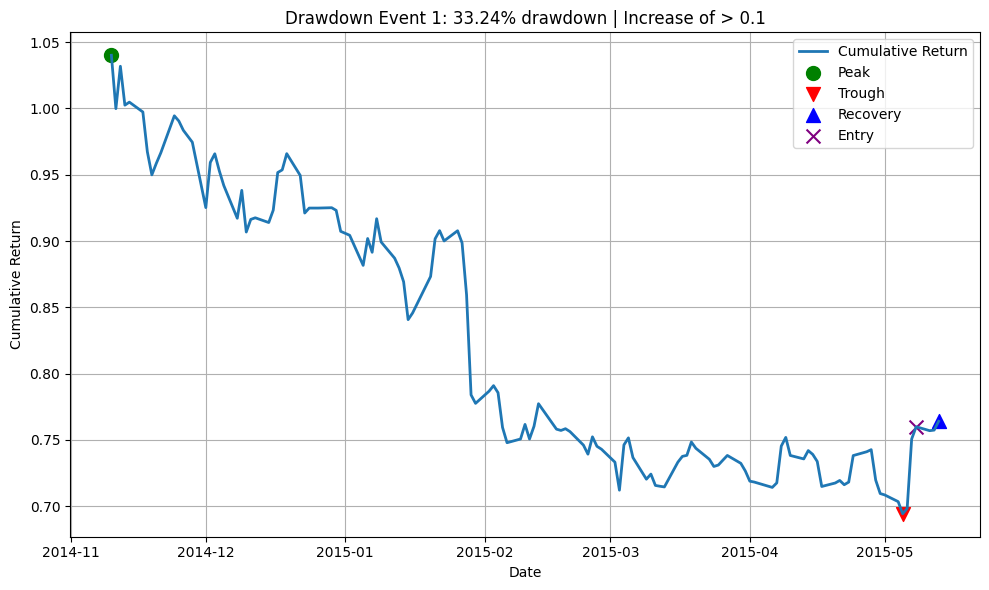

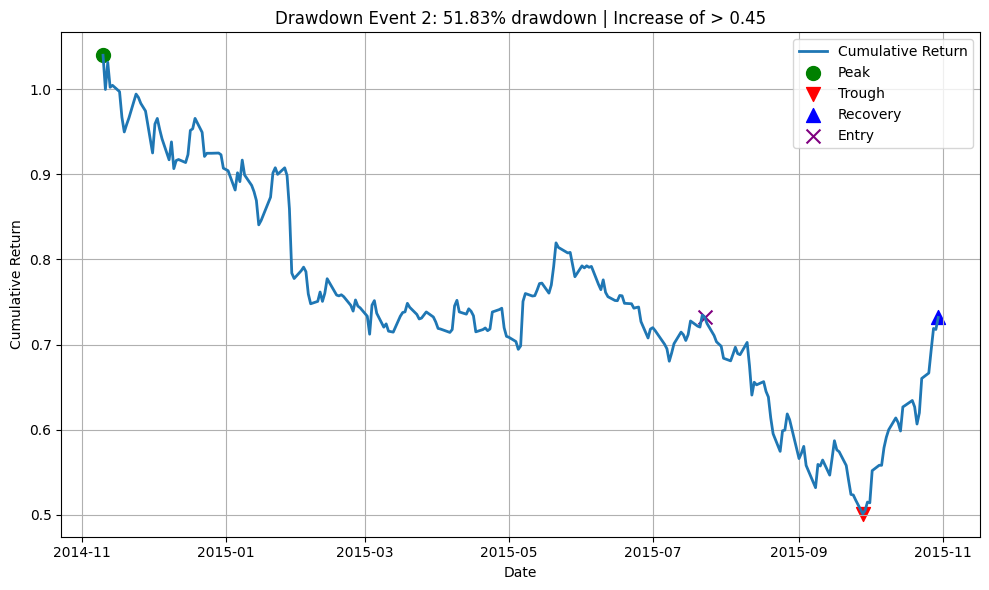

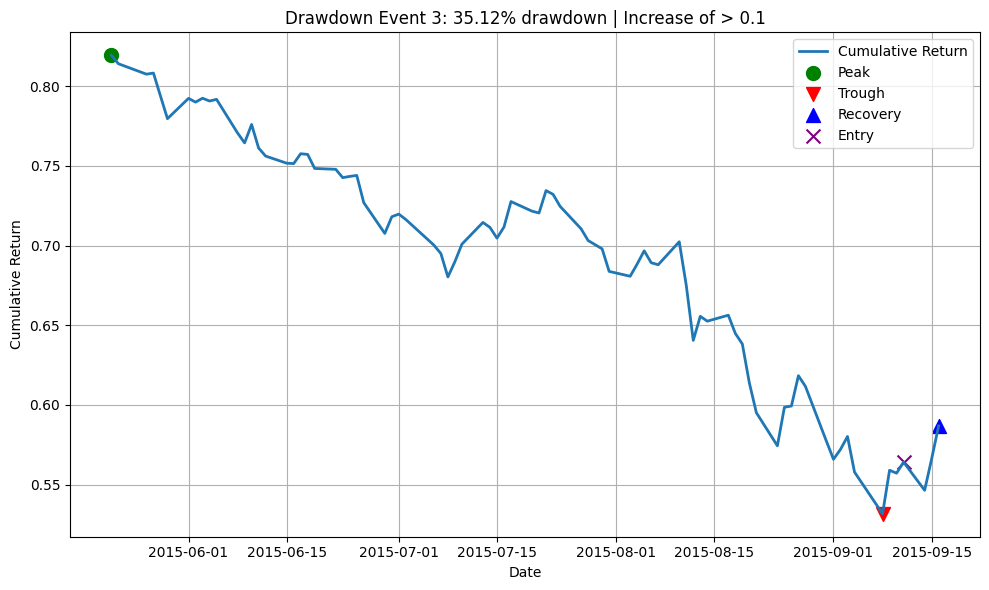

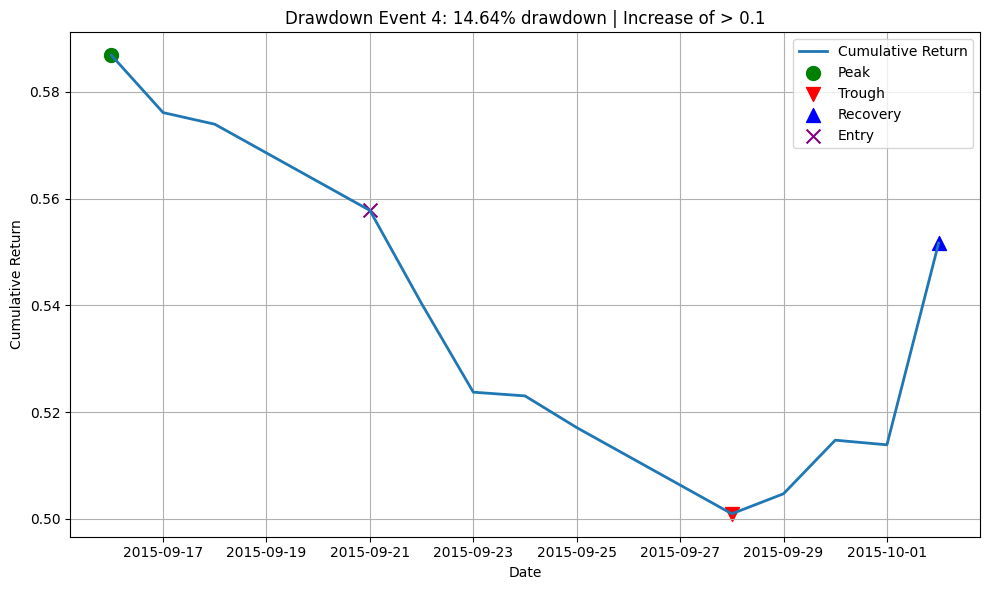

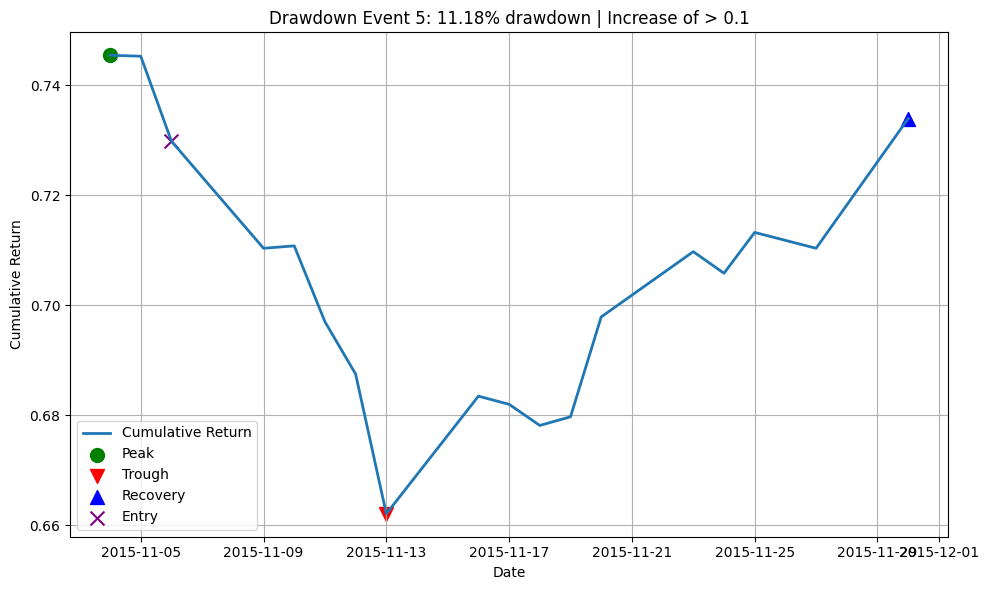

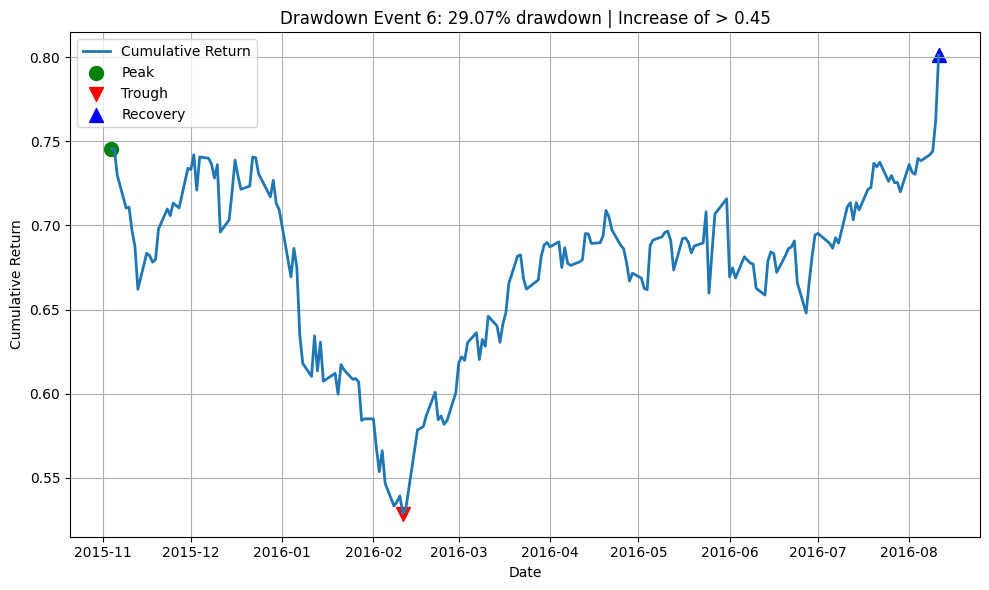

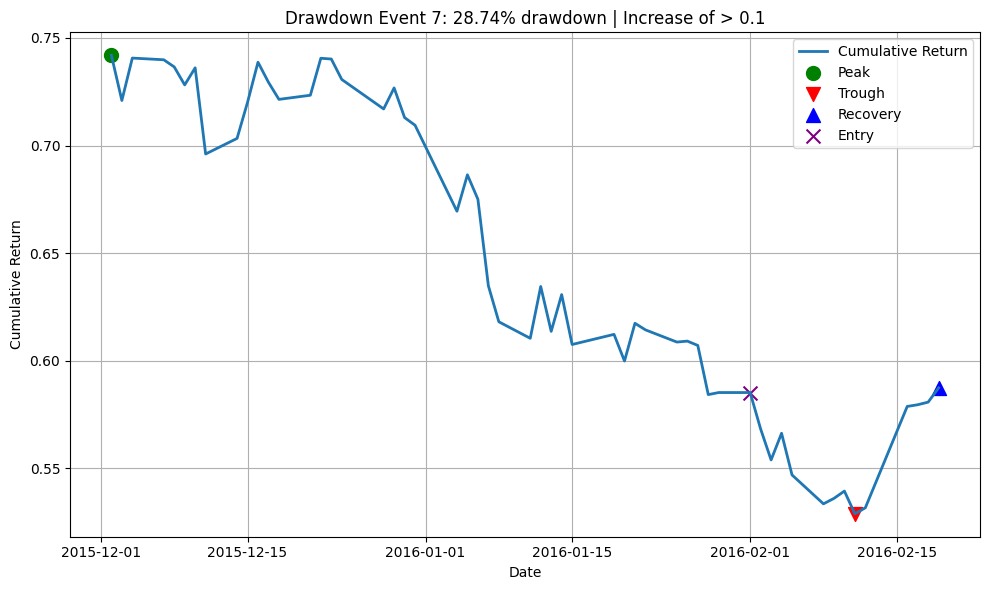

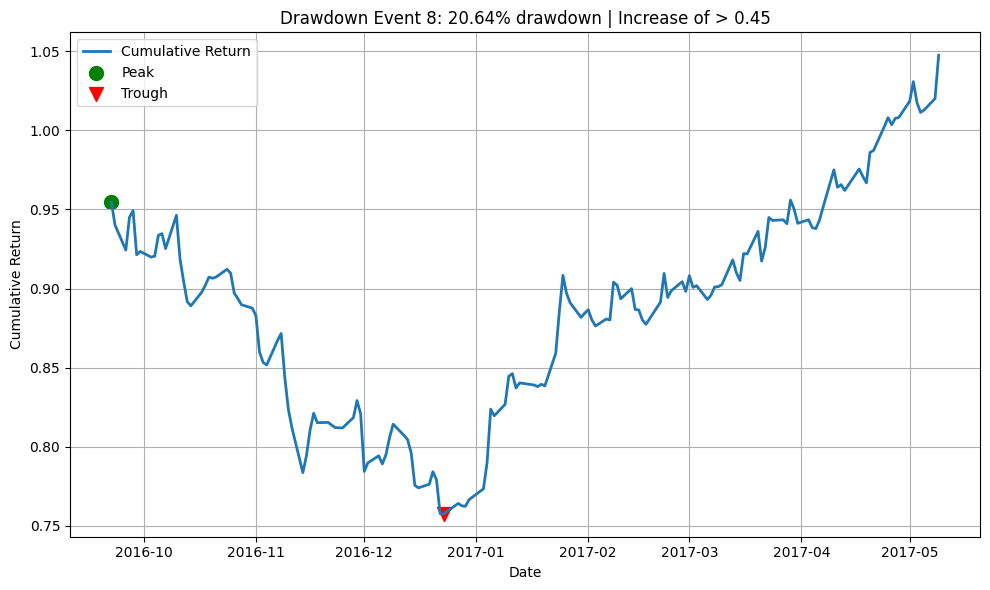

In [385]:
if valid_events:
    first_event = valid_events[0]
    
    # Define the analysis period from the first event's peak until its recovery (or end of data)
    start_date = first_event['peak_date']
    end_date = first_event['recovery_date'] if first_event['recovery_date'] else data.index[-1]
    event_data = data.loc[start_date:end_date].copy()
    
    if event_data.empty:
        print("No data available in the selected period.")
    else:
        # Recalculate cumulative returns for this sub-period
        event_data['cumret'] = event_data['Log Returns'].cumsum().apply(np.exp)
        event_data['cummax'] = event_data['cumret'].cummax()
        
        recovery_thresholds = [0.1, 0.2, 0.3, 0.4,0.45]
        drop_threshold = 0.1  # fixed drop threshold to trigger drawdown
        
        all_events = []
        
        # Loop over the different recovery thresholds
        for current_threshold in recovery_thresholds:
            # Initialize variables for drawdown detection (for this threshold)
            current_peak_date = event_data.index[0]
            current_peak_value = event_data['cumret'].iloc[0]
            in_drawdown = False
            trough_value = None
            trough_date = None
            recovery_value = None  # for tracking
            
            # Iterate over the data to detect drawdown events using the current recovery threshold
            for date, row in event_data.iterrows():
                current_value = row['cumret']
                if isinstance(current_value, pd.Series):
                    current_value = current_value.iloc[0]
                
                if not in_drawdown:
                    # Update peak if a new high is reached
                    if current_value > current_peak_value:
                        current_peak_date = date
                        current_peak_value = current_value
                    
                    # Check if a drop of at least drop_threshold (10%) has occurred
                    drawdown = (current_peak_value - current_value) / current_peak_value
                    if drawdown >= drop_threshold:
                        in_drawdown = True
                        trough_date = date
                        trough_value = current_value
                else:
                    # Update trough if a lower value is reached during the drawdown
                    if current_value < trough_value:
                        trough_date = date
                        trough_value = current_value
                        recovery_value = current_value
                    
                    # Check if cumulative return has recovered by an additive amount equal to current_threshold from the trough
                    if current_value >= trough_value * (1 + current_threshold):
                        duration = date - trough_date
                        drawdown_period = date - current_peak_date
                        recovery_value = current_value
                        recovery_pct = (recovery_value - trough_value) / trough_value * 100
                        drawdown_pct = (current_peak_value - trough_value) / current_peak_value * 100
                        event_dict = {
                            'Peak Date': current_peak_date,
                            'Trough Date': trough_date,
                            'Recovery Date': date,
                            'Entry Date': None,
                            'Overall Drawdown Period': drawdown_period,
                            'Overall Drawdown Percentage': round(drawdown_pct, 2),
                            'Recovery Percentage': round(recovery_pct, 2),
                            'Recovery Threshold': current_threshold,
                            'Recovery Duration': duration,
                        }
                        all_events.append(event_dict)
                        
                        # Reset drawdown state
                        in_drawdown = False
                        current_peak_date = date
                        current_peak_value = current_value
            # If still in drawdown at the end for this threshold, record the event with no recovery date
            if in_drawdown:
                duration = event_data.index[-1] - trough_date
                drawdown_period = event_data.index[-1] - current_peak_date
                final_value = event_data['cumret'].iloc[-1]
                recovery_pct = (final_value - trough_value) / trough_value * 100
                drawdown_pct = (current_peak_value - trough_value) / current_peak_value * 100
                event_dict = {
                    'Peak Date': current_peak_date,
                    'Trough Date': trough_date,
                    'Recovery Date': None,
                    'Entry Date': None,
                    'Overall Drawdown Period': drawdown_period,
                    'Overall Drawdown Percentage': round(drawdown_pct, 2),
                    'Recovery Percentage': round(recovery_pct, 2),
                    'Recovery Threshold': current_threshold,
                    'Recovery Duration': duration
                }
                all_events.append(event_dict)
        
        # Filter events: if multiple events share the same Peak and Trough, keep the one with the highest recovery threshold
        best_events = {}
        for event in all_events:
            key = (event['Peak Date'], event['Trough Date'])
            if key not in best_events or event['Recovery Threshold'] > best_events[key]['Recovery Threshold']:
                best_events[key] = event
        final_events = list(best_events.values())
        final_events.sort(key=lambda x: x['Peak Date'])

        def get_value(date, col):
            val = event_data.loc[date, col]
            return val.iloc[0] if isinstance(val, pd.Series) else val

        for event in final_events:
            entry_date_found = None  # reset for each event
            if pd.notnull(event['Recovery Date']):
                cutoff_date = event['Recovery Date'] - pd.Timedelta(days=3)
                if cutoff_date >= event['Peak Date']:
                    search_period = event_data.loc[event['Peak Date']:cutoff_date]
                    for decimals in [4, 3, 2, 1]:
                        recovery_val = round(get_value(event['Recovery Date'], 'cumret'), decimals)
                        matching_dates = [d for d in search_period.index if round(get_value(d, 'cumret'), decimals) == recovery_val]
                        if matching_dates:
                            entry_date_found = matching_dates[-1]
                            break  
            event['Entry Date'] = entry_date_found

       
        # Print a summary table of final events
        print("Summary of Drawdown Events (best by Recovery Threshold):")
        events_df = pd.DataFrame(final_events)
        print(events_df)
        
        # Plot each event
        for i, event in enumerate(final_events):
            plot_start = event['Peak Date']
            plot_end = event['Recovery Date'] if event['Recovery Date'] is not None else event_data.index[-1]
            event_period = event_data.loc[plot_start:plot_end]
            
            plt.figure(figsize=(10, 6))
            plt.plot(event_period.index, event_period['cumret'], label='Cumulative Return', lw=2)
            
            # Helper function to safely retrieve scalar values from event_data
            def get_value(date, col):
                val = event_data.loc[date, col]
                return val.iloc[0] if isinstance(val, pd.Series) else val
            
            # Mark peak, trough, and recovery
            peak_val = get_value(event['Peak Date'], 'cumret')
            plt.scatter(event['Peak Date'], peak_val, color='green', marker='o', s=100, label='Peak')
            trough_val = get_value(event['Trough Date'], 'cumret')
            plt.scatter(event['Trough Date'], trough_val, color='red', marker='v', s=100, label='Trough')
            if event['Recovery Date'] is not None:
                recovery_val = get_value(event['Recovery Date'], 'cumret')
                plt.scatter(event['Recovery Date'], recovery_val, color='blue', marker='^', s=100, label='Recovery')
    
                if event['Entry Date'] is not None:
                    entry_val = get_value(event['Entry Date'], 'cumret')
                    plt.scatter(event['Entry Date'], entry_val, color='purple', marker='x', s=100, label='Entry')

            
            plt.title(f"Drawdown Event {i+1}: {event['Overall Drawdown Percentage']}% drawdown | Increase of > {event['Recovery Threshold']}")
            plt.xlabel("Date")
            plt.ylabel("Cumulative Return")
            plt.legend(loc='best')
            plt.grid(True)
            plt.tight_layout()
            plt.show()




In [358]:
# For each event, if a recovery date exists, find the most recent matching entry date
decimal_places = 1  # adjust as needed
for event in final_events:
    if event['Recovery Date'] is not None:
        recovery_val = round(get_value(event['Recovery Date'], 'cumret'), decimal_places)
        
        search_period = event_data.loc[event['Peak Date']:event['Recovery Date']]
        search_period = search_period.loc[search_period.index < event['Recovery Date']]

        matching_dates = [d for d in search_period.index if round(get_value(d, 'cumret'), decimal_places) == recovery_val]
        
        if matching_dates:
            event['Entry Date'] = matching_dates[-1]  # Most recent matching date
        else:
            event['Entry Date'] = None

        # Print debugging info
        print(f"Event: {event}")
        print(f"Recovery Date: {event['Recovery Date']}, Recovery Value: {recovery_val}")
        print(f"Matching Dates: {matching_dates}")
        print(f"Selected Entry Date: {event['Entry Date']}\n")

   


Event: {'Peak Date': Timestamp('2014-11-10 00:00:00'), 'Trough Date': Timestamp('2015-05-05 00:00:00'), 'Recovery Date': Timestamp('2015-05-13 00:00:00'), 'Overall Drawdown Period': Timedelta('184 days 00:00:00'), 'Overall Drawdown Percentage': np.float64(33.24), 'Recovery Percentage': np.float64(10.05), 'Recovery Threshold': 0.1, 'Recovery Duration': Timedelta('8 days 00:00:00'), 'Entry Date': Timestamp('2015-05-12 00:00:00')}
Recovery Date: 2015-05-13 00:00:00, Recovery Value: 0.8
Matching Dates: [Timestamp('2015-01-15 00:00:00'), Timestamp('2015-01-16 00:00:00'), Timestamp('2015-01-29 00:00:00'), Timestamp('2015-01-30 00:00:00'), Timestamp('2015-02-02 00:00:00'), Timestamp('2015-02-03 00:00:00'), Timestamp('2015-02-04 00:00:00'), Timestamp('2015-02-05 00:00:00'), Timestamp('2015-02-09 00:00:00'), Timestamp('2015-02-10 00:00:00'), Timestamp('2015-02-11 00:00:00'), Timestamp('2015-02-12 00:00:00'), Timestamp('2015-02-13 00:00:00'), Timestamp('2015-02-17 00:00:00'), Timestamp('2015-02-